In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d


In [2]:
f0 = 1800  # Гц
Vmod = 1200  # Бод
Vinf = 2400  # бит/

T = 1 / Vmod
q = 2 ** (Vinf // Vmod)
A = 1  # амплитуда


In [3]:
t = np.linspace(0, T, 1000)
phi1 = np.sqrt(2 / T) * np.cos(2 * np.pi * f0 * t)
phi2 = np.sqrt(2 / T) * np.sin(2 * np.pi * f0 * t)
Pexp = []
Pteor = []
Pteor242 = []


def signal_point(i):
    i1 = i // np.sqrt(q)
    i2 = i % np.sqrt(q)
    si1 = A * (1 - ((2 * i1) / (np.sqrt(q) - 1)))
    si2 = A * (1 - ((2 * i2) / (np.sqrt(q) - 1)))
    return si1 * phi1 + si2 * phi2


def signal_features(f):
    return np.trapz(f * phi1, t), np.trapz(f * phi2, t)


signal_indices = np.arange(q)
signal_constellation = [signal_features(signal_point(j)) for j in signal_indices]
received_signal_constellation = []


def distance(x1, y1):
    distances = [np.power(x1 - x2, 2) + np.power(y1 - y2, 2) for x2, y2 in signal_constellation]
    return np.argmin(distances)


def plot_constellations(SNRdB):
    fig, ax = plt.subplots(figsize=(10, 10))

    x, y = zip(*signal_constellation)
    ax.scatter(x, y, color='blue', s=30, label='Original Signal Constellation')

    x, y = zip(*received_signal_constellation)
    ax.scatter(x, y, color='red', s=5, label='Received Signal Constellation')

    try:
        vor = Voronoi(signal_constellation)
        voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='black', line_width=2, line_alpha=0.6)
    except Exception as e:
        print(f"Error generating Voronoi diagram: {e}")

    plt.axis([-1.5, 1.5, -1.5, 1.5])
    plt.legend()
    plt.xlabel('s1')
    plt.ylabel('s2')
    plt.title(f'SNRdB = {SNRdB}')
    plt.show()


1 0.2612244897959184


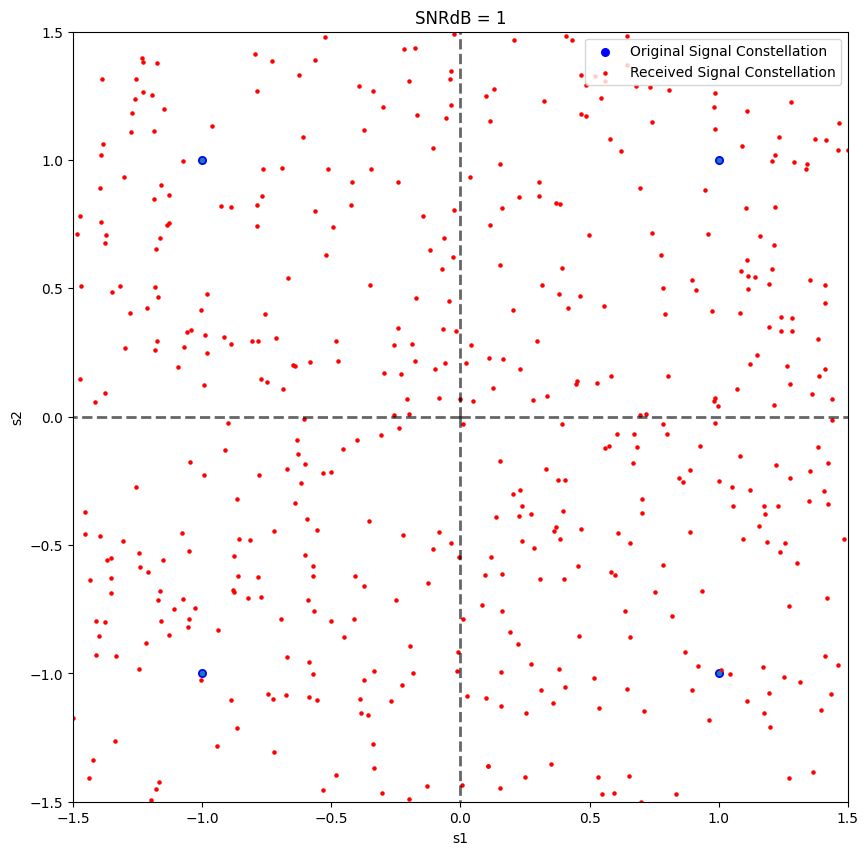

2 0.1841726618705036


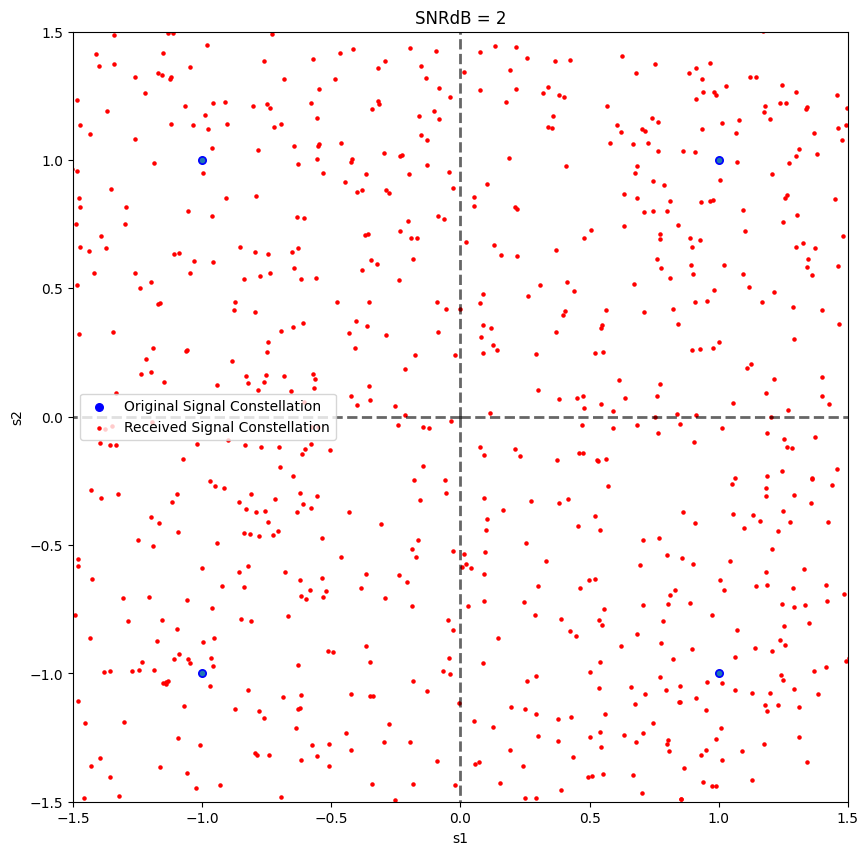

3 0.143658810325477


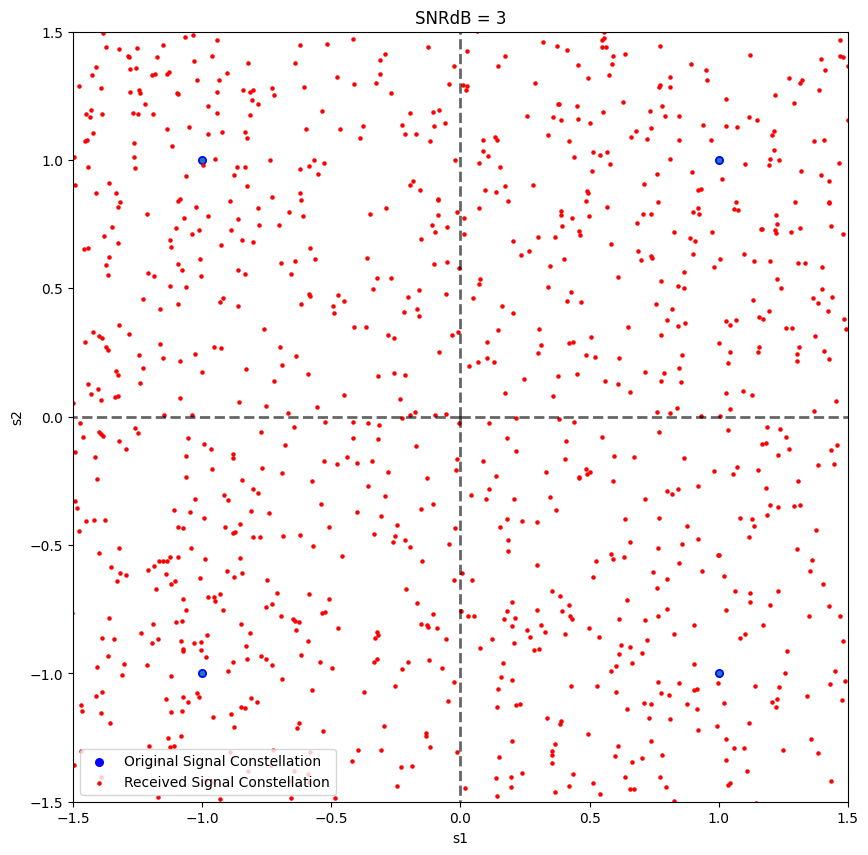

4 0.10697868783953197


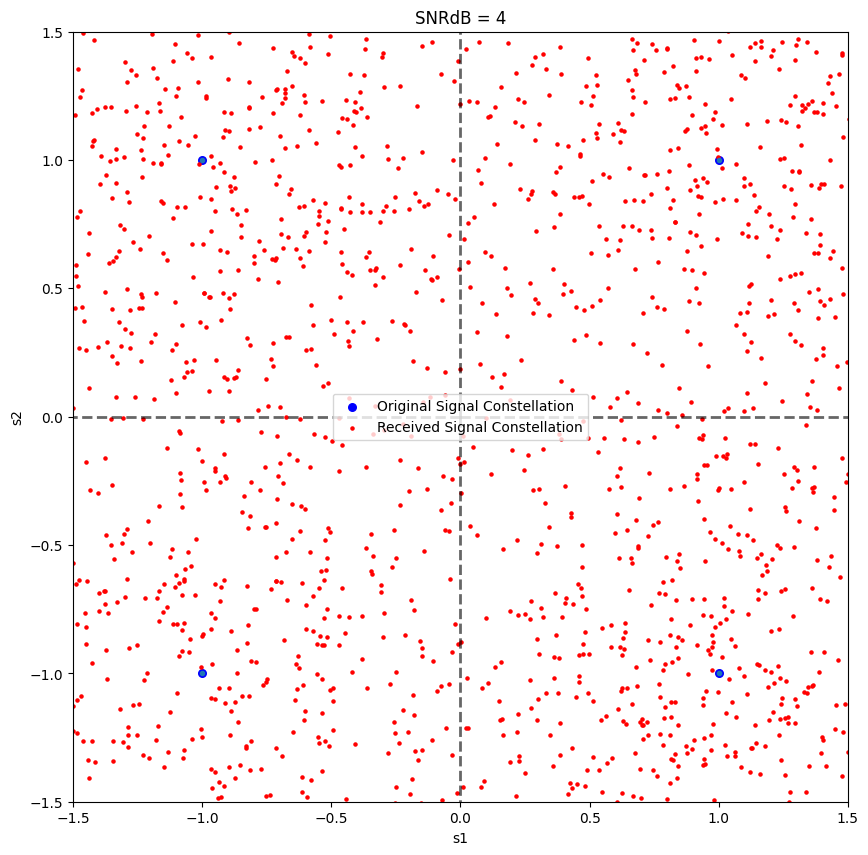

5 0.0700027344818157


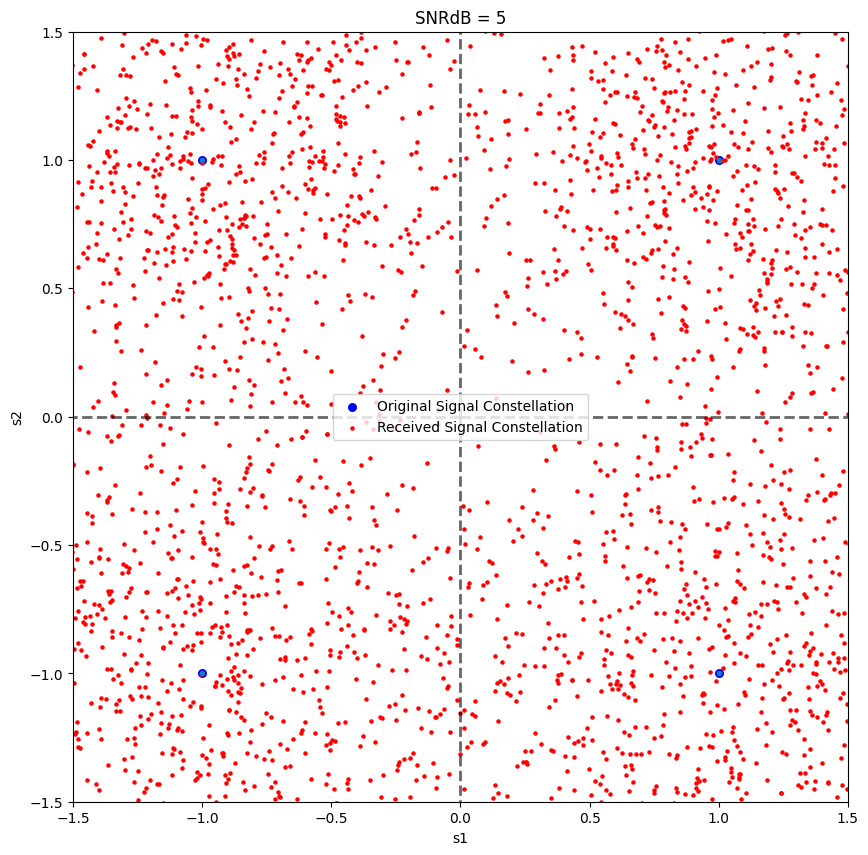

6 0.04463818657367045


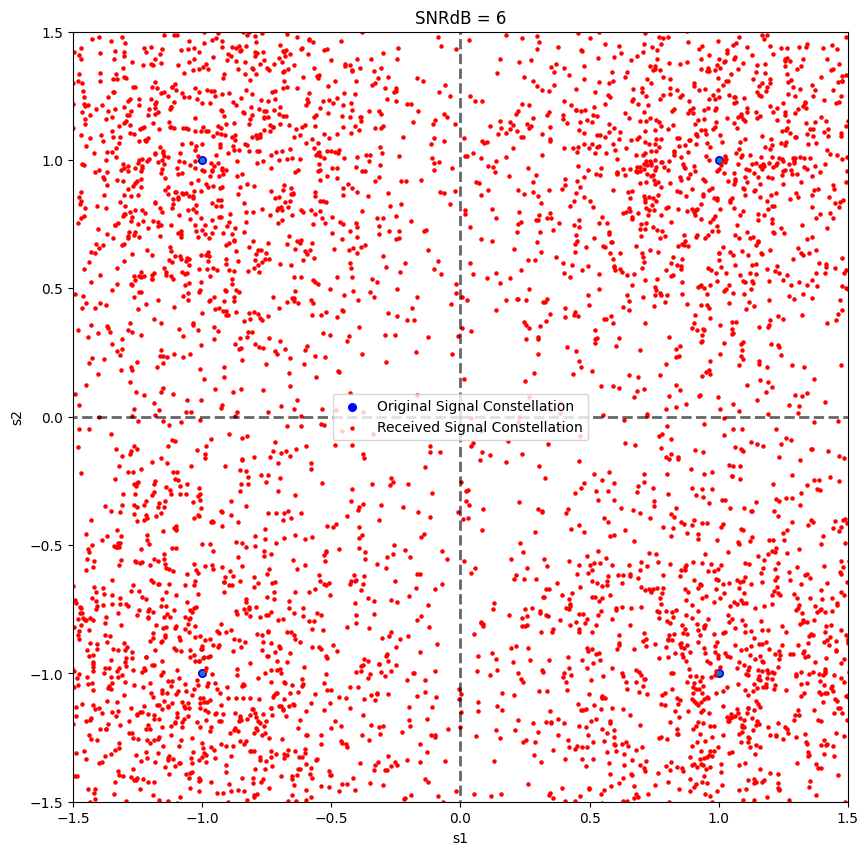

7 0.028340529170818113


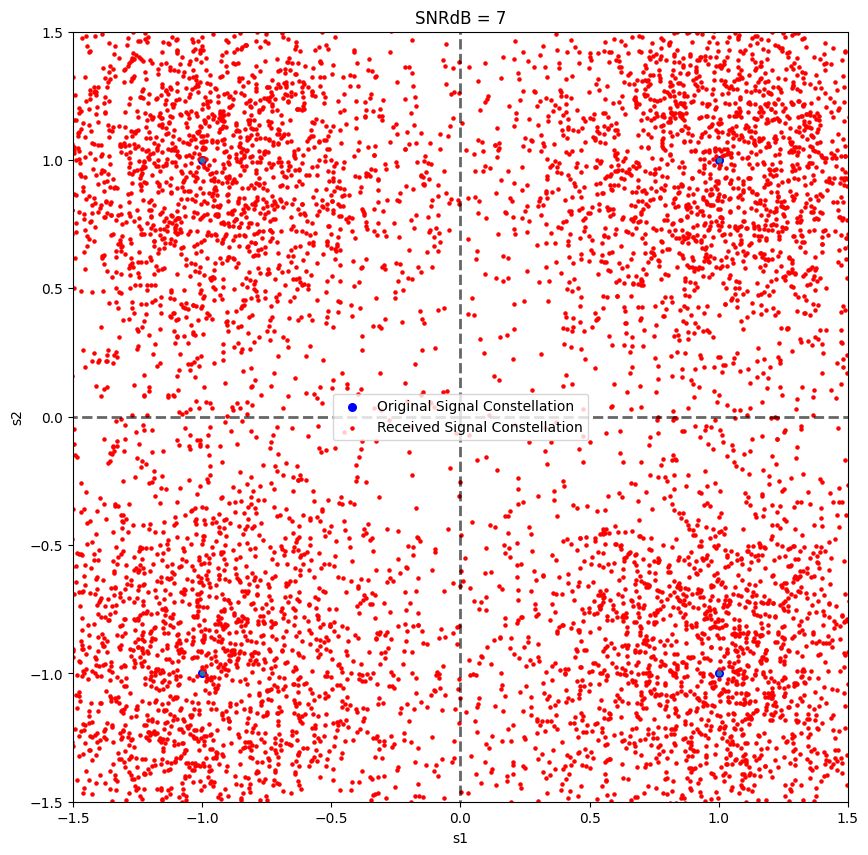

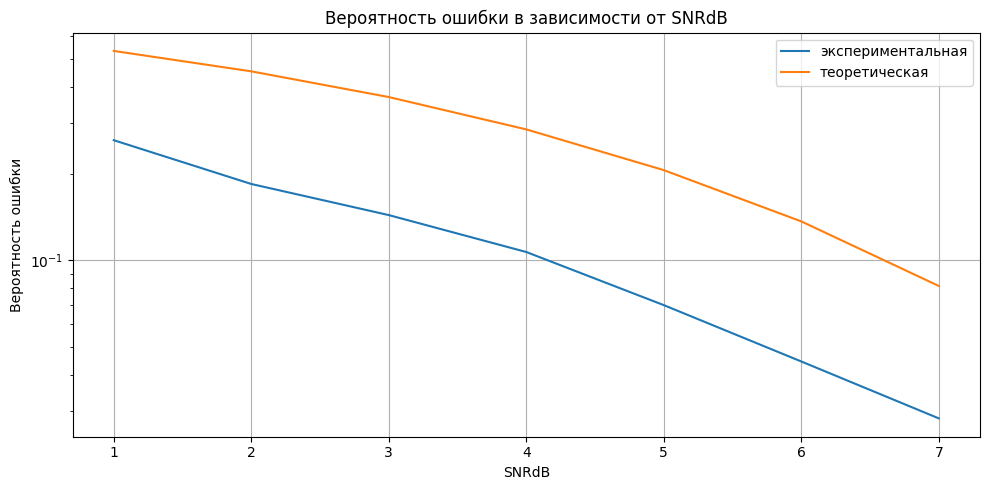

In [4]:
E = np.mean([np.power(np.linalg.norm(signal_point(i)), 2) for i in signal_indices])

SNRdB_values = np.arange(1, 8)
for SNRdB in SNRdB_values:
    received_signal_constellation = []
    SNR_linear = np.power(10, SNRdB / 10)
    N0 = E / SNR_linear
    sigma = np.sqrt(N0 / 2)
    Nmax = 256
    Nerr = 0
    Ntest = 0

    while Nerr < Nmax:
        j = np.random.randint(q)
        r = signal_point(j) + np.random.standard_normal(t.shape) * sigma
        received_signal_constellation.append(signal_features(r))
        x, y = signal_features(r)
        if j != distance(x, y):
            Nerr += 1
        Ntest += 1

    pe1 = Nerr / Ntest
    pe2 = np.exp(-3 * E / (2 * (q - 1) * N0))  # (2.43)

    Pexp.append(pe1)
    Pteor.append(pe2)

    print(SNRdB, pe1)
    plot_constellations(SNRdB)

plt.figure(figsize=(10, 5))
plt.plot(SNRdB_values, Pexp, label='экспериментальная')
plt.plot(SNRdB_values, Pteor, label='теоретическая')
plt.yscale('log')
plt.xlabel('SNRdB')
plt.ylabel('Вероятность ошибки')
plt.legend()
plt.title('Вероятность ошибки в зависимости от SNRdB')
plt.grid()
plt.tight_layout()
plt.show()
